In [1]:
import os
import pyemu
import flopy
from pathlib import Path
import shutil
import pandas as pd

In [2]:
org_ws = Path('../MV_Model_Files/')
new_ws = 'simple_ies'
exe_dir = Path('../bin/mac/')

In [3]:
if os.path.exists(new_ws):
    shutil.rmtree(new_ws)
shutil.copytree(org_ws, new_ws)

'simple_ies'

In [4]:
sim = flopy.mf6.MFSimulation.load(sim_ws = new_ws)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package chd...
    loading package rch...
    loading package riv...
    loading package wel...
    loading package obs...
  loading solution package at...


In [5]:
shutil.copy2(os.path.join(exe_dir,'mf6'),os.path.join(new_ws,'mf6'))

'simple_ies/mf6'

In [6]:
pyemu.os_utils.run('mf6',cwd=new_ws)

                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

        MODFLOW 6 compiled May 12 2025 12:37:58 with GCC version 13.3.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Software User Rights Notice for complete use, copyright, 
and distribution information

In [7]:
#need a spatial reference to use pilot points. this means xoff, yoff, rotation, epsg
m=sim.get_model()
m.modelgrid

xll:0.0; yll:0.0; rotation:0.0; units:feet; lenuni:1

In [8]:
pf = pyemu.utils.PstFrom(original_d=new_ws,
                         new_d='template',
                         remove_existing=True,
                         start_datetime="1-1-2025",
                         spatial_reference=m.modelgrid)

2025-07-08 14:06:28.893048 starting: opening PstFrom.log for logging
2025-07-08 14:06:28.893552 starting PstFrom process
2025-07-08 14:06:28.894227 starting: setting up dirs
2025-07-08 14:06:28.894499 starting: removing existing new_d 'template'
2025-07-08 14:06:28.906811 finished: removing existing new_d 'template' took: 0:00:00.012312
2025-07-08 14:06:28.906938 starting: copying original_d 'simple_ies' to new_d 'template'
2025-07-08 14:06:28.925021 finished: copying original_d 'simple_ies' to new_d 'template' took: 0:00:00.018083
2025-07-08 14:06:28.925262 finished: setting up dirs took: 0:00:00.031035


In [9]:
?pf.add_parameters

Signature:
pf.add_parameters(
    filenames,
    par_type,
    zone_array=None,
    dist_type='gaussian',
    sigma_range=4.0,
    upper_bound=None,
    lower_bound=None,
    transform=None,
    par_name_base='p',
    index_cols=None,
    use_cols=None,
    use_rows=None,
    pargp=None,
    pp_space=10,
    use_pp_zones=False,
    num_eig_kl=100,
    spatial_reference=None,
    geostruct=None,
    datetime=None,
    mfile_fmt='free',
    mfile_skip=None,
    mfile_sep=None,
    ult_ubound=None,
    ult_lbound=None,
    rebuild_pst=False,
    alt_inst_str='inst',
    comment_char=None,
    par_style='multiplier',
    initial_value=None,
)
Docstring:
Add list or array style model input files to PstFrom object.
This method is the main entry point for adding parameters to the
pest interface

Args:
    filenames (`str`): Model input filenames to parameterize. By default filename should give relative
        loction from top level of pest template directory
        (`new_d` as passed to `Ps

In [10]:
k_pars = [f for f in os.listdir(new_ws) if 'k_' in f and f.endswith('.ref')]
k_pars
for f in k_pars:
    pf.add_parameters(f,par_type='constant',upper_bound=20,lower_bound=0.05)

2025-07-08 14:06:38.911128 transform was not passed, setting default tranform to 'log'
2025-07-08 14:06:38.911816 starting: adding constant type m style parameters for file(s) ['k_aq.ref']
2025-07-08 14:06:38.912090 starting: loading array template/k_aq.ref
2025-07-08 14:06:38.913374 finished: loading array template/k_aq.ref took: 0:00:00.001284
2025-07-08 14:06:38.913611 loaded array 'simple_ies/k_aq.ref' of shape (40, 25)
2025-07-08 14:06:38.915981 starting: writing array-style template file 'template/p_inst0_constant.csv.tpl'
2025-07-08 14:06:38.916085 starting: writing template file template/p_inst0_constant.csv.tpl for ['p_inst:0']
2025-07-08 14:06:38.923746 finished: writing template file template/p_inst0_constant.csv.tpl for ['p_inst:0'] took: 0:00:00.007661
2025-07-08 14:06:38.923820 starting: writing array-based template file 'template/p_inst0_constant.csv.tpl'
2025-07-08 14:06:38.928191 finished: adding constant type m style parameters for file(s) ['k_aq.ref'] took: 0:00:00.0

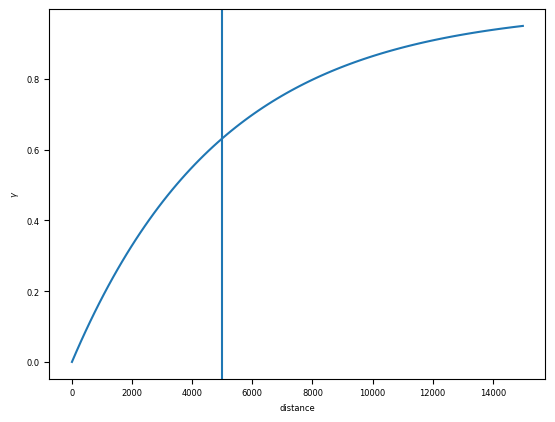

In [11]:
#for pilot points, we first need to build a variogram, which describes the underlying spatial correlation structure of the variable
pp_v = pyemu.geostats.ExpVario(contribution=1.0, a=5000) #rule of thumb is that range should be atleast 2x pp spacing (delr= 500
pp_gs = pyemu.geostats.GeoStruct(variograms=pp_v)
ax=pp_gs.plot()
ax.axvline(x=500*5*2)

In [ ]:
for f in k_pars:
    base = f.split('.')[0]
    pf.add_parameters(f,par_type='pilotpoint',upper_bound=20,lower_bound=0.05,pp_space=5,geostruct=pp_gs)

In [ ]:
?pf.add_observations

In [ ]:
obs_csvs = [f for f in os.listdir(new_ws) if f.endswith('.csv')]
for f in obs_csvs:
    df = pd.read_csv(os.path.join(new_ws,f))
    pf.add_observations(f,index_cols='time',use_cols=df.columns.tolist()[1:])

In [ ]:
pf.mod_sys_cmds.append('mf6')

In [ ]:
pf.build_pst(filename=os.path.join(pf.new_d,'at.pst'),version=2)

In [ ]:
pst = pyemu.Pst(filename=os.path.join(pf.new_d,'at.pst'))
obs = pst.observation_data
obs

In [ ]:
#zero everything out for starters
obs.weight = 0

In [ ]:
#we need to tell PEST what are the observed values and their weights, to calc the objective function
truth = pd.read_csv(os.path.join(new_ws,'obsvalues.dat'),delim_whitespace=True)
truth

In [ ]:
for i,stuff in truth.iterrows():
    obs.loc[obs.obsnme.str.contains(stuff.obsnme),'obsval'] = stuff.obsval
    obs.loc[obs.obsnme.str.contains(stuff.obsnme),'weight'] = stuff.weight
    obs.loc[obs.obsnme.str.contains(stuff.obsnme),'obgnme'] = stuff.obgnme

In [ ]:
pst.observation_data = obs
pst.write(os.path.join(pf.new_d,'at.pst'),version=2)

In [ ]:
pyemu.os_utils.run('pestpp-ies at.pst',cwd='template')

In [ ]:
phi= pst.phi
phi